# Estimating Aboveground Biomass in a Protected Area using GEDI L4A dataset

## Overview
This tutorial will demonstrate how to directly access and subset the GEDI L4A dataset using [NASA's Harmony Services](https://harmony.earthdata.nasa.gov/) and compute a summary of aboveground biomass density for a protected area in Mexico. The Harmony API allows seamless access and production of  analysis-ready Earth observation data across different DAACs by enabling cloud-based spatial, temporal, and variable subsetting and data conversions.  The GEDI L4A dataset is available from the Harmony API. 

## Learning Objectives
- Use [NASA's Harmony Services](https://harmony.earthdata.nasa.gov/) to retrieve the GEDI L4A dataset. The Harmony API allows access to selected variables for the dataset within the spatial-temporal bounds without having to download the whole data file.
- Compute summaries of AGBD across various plant functional types (PFTs) in the study area.

## Dataset 
The [Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD)](https://doi.org/10.3334/ORNLDAAC/2056) dataset provides predictions of the aboveground biomass density (AGBD; in Mg/ha) and estimates of the prediction standard error within each sampled geolocated GEDI footprint. GEDI L4A dataset is available for the period starting 2019-04-17 and covers 52 N to 52 S latitudes. GEDI L4A data files are natively in HDF5 format. GEDI L4A dataset should be cited as:
- Dubayah, R.O., J. Armston, J.R. Kellner, L. Duncanson, S.P. Healey, P.L. Patterson, S. Hancock, H. Tang, J. Bruening, M.A. Hofton, J.B. Blair, and S.B. Luthcke. 2022. GEDI L4A Footprint Level Aboveground Biomass Density, Version 2.1. ORNL DAAC, Oak Ridge, Tennessee, USA. doi:10.3334/ORNLDAAC/2056


## Requirements
### 1. Compute environment
This notebook can be run in any personal computing environment (e.g., desktop/laptops), on-premise solution (e.g., High-Performance Computing), or on the Cloud (e.g., Amazon Web Service).

### 2. Earthdata Login
An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

### 3. Additional Requirements
While NASA's Harmony services are available directly through RESTful API, we will use [Harmony-Py](https://github.com/nasa/harmony-py) Python library for this tutorial. Harmony-Py provides a friendly interface for integrating with NASA's Harmony Services. In addition to Harmony-Py, this tutorial requires the following Python modules installed in your system: `earthaccess`, `h5py`, `requests`, `datetime`, `pandas`, `geopandas`, `contextily`. 

```bash
pip install -U harmony-py, h5py, requests, datetime, pandas, geopandas, contextily
```
## Import Modules

In [1]:
import h5py
import requests as re
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from datetime import datetime
from glob import glob
from harmony import Client, Collection, Environment, Request
import seaborn as sns
sns.set(style='whitegrid')

## Authentication
NASA Harmony API requires [NASA Earthdata Login (EDL)](https://urs.earthdata.nasa.gov/). You can use the [earthaccess](https://nsidc.github.io/earthaccess/) Python library to set up authentication. Alternatively, you can also login to `harmony_client` directly by passing EDL authentication as the following in the Jupyter Notebook itself:

```
harmony_client = Client(auth=("your EDL username", "your EDL password"))
```

## Create Harmony Client Object
First, we create a Harmony Client object. If you are passing the EDL authentication, please do as shown above with the `auth` parameter.

In [2]:
harmony_client = Client()

## Retrieve Concept ID
Now, let's retrieve the `Concept ID` of the GEDI L4A dataset. The `Concept ID` is NASA Earthdata's unique ID for its dataset. 

In [3]:
# GEDI L4A DOI 
doi = '10.3334/ORNLDAAC/2056'

# CMR API base url
doisearch = f'https://cmr.earthdata.nasa.gov/search/collections.json?doi={doi}' 
concept_id = re.get(doisearch).json()['feed']['entry'][0]['id']
concept_id

'C2237824918-ORNL_CLOUD'

## Define Request Parameters 

Let's create a Harmony Collection object with the concept_id retrieved above. We will also define the GEDI L4A variables of interest and temporal range.

In [4]:
collection = Collection(id=concept_id)
# gedi beams
beams = ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
# gedi variables
variables = ['agbd', 'l4_quality_flag', 'elev_lowestmode', 'land_cover_data/pft_class']
# combine variables and beams
variables = [f'/{b}/{v}' for b in beams for v in variables]
temporal_range = {'start': datetime(2019, 4, 17), 
                  'stop': datetime(2023, 3, 31)}

We will use the spatial extent of the [La Primavera Biosphere Reserve](https://en.wikipedia.org/wiki/La_Primavera_Biosphere_Reserve), a protected natural area in western Mexico, provided as a GeoJSON file at `bosque_primavera.json`. Let's open and plot this file.

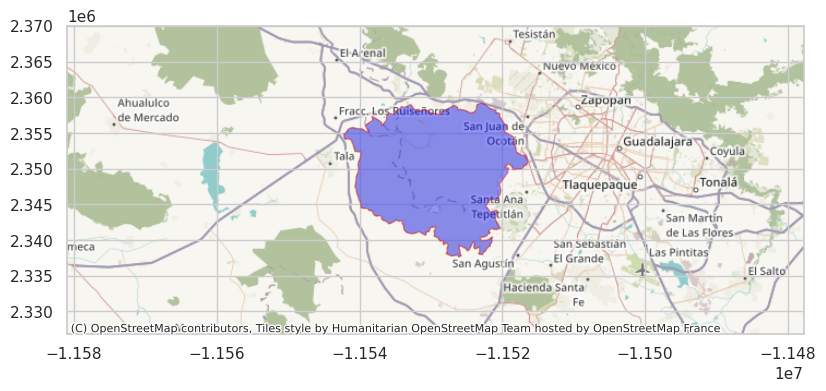

In [5]:
poly_json = '../data-access/bosque_primavera.json'
poly = gpd.read_file(poly_json) 
ax=poly.to_crs(epsg=3857).plot(figsize=(10, 4), alpha=0.4, color='blue', edgecolor='red')
plt.margins(y=0.5, x=1.5)
ctx.add_basemap(ax)

## Create and Submit Harmony Request
Now, we can create a Harmony request with variables, temporal range, and bounding box and submit the request using the Harmony client object. We will use the `download_all` method, which uses a multithreaded downloader and returns a [concurrent future](https://docs.python.org/3/library/concurrent.futures.html). Futures are asynchronous and let us use the downloaded file as soon as the download is complete while other files are still being downloaded. 

In [6]:
request = Request(collection=collection, 
                  variables=variables, 
                  temporal=temporal_range,
                  shape=poly_json,
                  ignore_errors=True)

# submit harmony request, will return job id
subset_job_id = harmony_client.submit(request)

print(f'Processing job: {subset_job_id}')

print(f'Waiting for the job to finish')
results = harmony_client.result_json(subset_job_id, show_progress=True)

print(f'Downloading subset files...')
futures = harmony_client.download_all(subset_job_id, overwrite=False)
for f in futures:
    # all subsetted files have this suffix
    if f.result().endswith('subsetted.h5'):
        print(f'Downloaded: {f.result()}')
            
print(f'Done downloading files.')

Processing job: b7dfe272-7c9d-40d0-af68-71aaa056a5b2
Waiting for the job to finish


 [ Processing:  86% ] |###########################################        | [|]
Job is running with errors.
 [ Processing: 100% ] |###################################################| [|]


GEDI04_A_2020138102210_O08093_03_T04765_02_002_02_V002_subsetted.h5
Downloaded: GEDI04_A_2020138102210_O08093_03_T04765_02_002_02_V002_subsetted.h5
GEDI04_A_2019110215109_O02004_03_T03189_02_002_02_V002_subsetted.h5
Downloaded: GEDI04_A_2019110215109_O02004_03_T03189_02_002_02_V002_subsetted.h5
GEDI04_A_2020055190255_O06812_03_T02072_02_002_02_V002_subsetted.h5
Downloaded: GEDI04_A_2020055190255_O06812_03_T02072_02_002_02_V002_subsetted.h5
GEDI04_A_2020251133701_O09847_03_T08881_02_002_02_V002_subsetted.h5
Downloaded: GEDI04_A_2020251133701_O09847_03_T08881_02_002_02_V002_subsetted.h5
GEDI04_A_2019120085608_O02151_02_T02464_02_002_02_V002_subsetted.h5
Downloaded: GEDI04_A_2019120085608_O02151_02_T02464_02_002_02_V002_subsetted.h5
GEDI04_A_2020160162505_O08438_02_T03734_02_002_02_V002_subsetted.h5
Downloaded: GEDI04_A_2020160162505_O08438_02_T03734_02_002_02_V002_subsetted.h5
GEDI04_A_2020255120326_O09908_03_T10457_02_002_02_V002_subsetted.h5
Downloaded: GEDI04_A_2020255120326_O09908_03

## Read Subset files
All the subsetted files are saved as `_subsetted.h5`. Let's read these `h5` files into the pandas dataframe.

In [7]:
subset_df = pd.DataFrame()
for subfile in glob('*_subsetted.h5'):
    hf_in = h5py.File(subfile, 'r')
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            col_names = []
            col_val = []
            # read all variables
            for key, value in beam.items():
                # check if the item is a group
                if isinstance(value, h5py.Group):
                    # looping through subgroups
                    for key2, value2 in value.items():
                        col_names.append(key2)
                        col_val.append(value2[:].tolist())
                else:
                    col_names.append(key)
                    col_val.append(value[:].tolist())

        # Appending to the subset_df dataframe
        beam_df = pd.DataFrame(map(list, zip(*col_val)), columns=col_names)
        subset_df = pd.concat([subset_df, beam_df])
    hf_in.close()
# print head of dataframe
subset_df.head()

,agbd,delta_time,elev_lowestmode,lat_lowestmode_a1,lon_lowestmode_a1,shot_number,l4_quality_flag,pft_class,shot_number,lat_lowestmode,lon_lowestmode,shot_number
0,82.577484,6.644999e+07,1540.948242,20.717487,-103.594671,65680000300329876,0,4,65680000300329876,20.717488,-103.594671,65680000300329876
1,17.222200,6.644999e+07,1539.156738,20.717087,-103.594327,65680000300329877,0,4,65680000300329877,20.717087,-103.594327,65680000300329877
2,11.274220,6.644999e+07,1538.657593,20.716686,-103.593983,65680000300329878,0,4,65680000300329878,20.716686,-103.593983,65680000300329878
3,22.247044,6.644999e+07,1538.058594,20.716285,-103.593640,65680000300329879,0,4,65680000300329879,20.716285,-103.593640,65680000300329879
4,11.021081,6.644999e+07,1538.167603,20.715884,-103.593297,65680000300329880,0,4,65680000300329880,20.715884,-103.593297,65680000300329880


## Quality Filter and Plot
We can now quality filter the dataset and only retrieve the good quality shots for trees and shrub cover plant functional types (PFTs). 

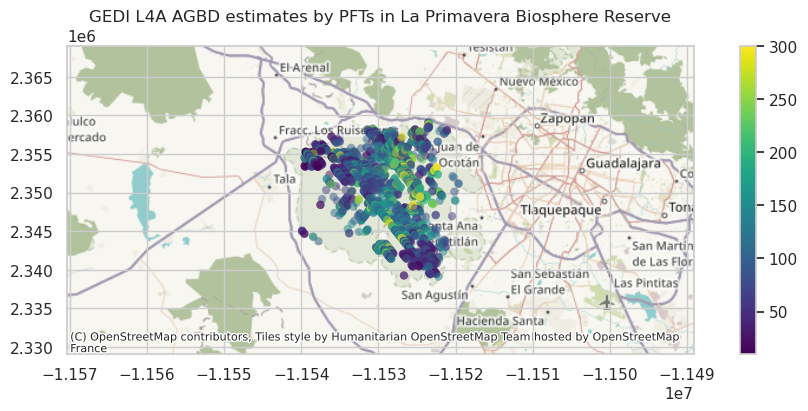

In [8]:
# MCD12Q1 PFT types
pft_legend = {0 : 'Water Bodies', 
              1: 'Evergreen Needleleaf Trees', 
              2: 'Evergreen Broadleaf Trees', 
              3: 'Deciduous Needleleaf Trees',  
              4: 'Deciduous Broadleaf Trees', 
              5: 'Shrub', 
              6: 'Grass',
              7: 'Cereal Croplands', 
              8: 'Broadleaf Croplands', 
              9: 'Urban and Built-up Lands', 
              10: 'Permanent Snow and Ice', 
              11: 'Barren', 
              255: 'Unclassified'}

# create geopandas dtframe
gdf = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df.lon_lowestmode, subset_df.lat_lowestmode))
# wgs84 coordinate
gdf.crs="EPSG:4326"
# creating mask with good quality shots and trees/shrubs pft class
mask = (gdf['l4_quality_flag']==1) & (gdf['pft_class'] <= 5 )
ax1= gdf.to_crs(epsg=3857)[mask].plot(column='agbd', alpha=0.5, vmax=300, cmap = 'viridis',
                                                      linewidth=0, legend=True, figsize=(12, 4))
plt.margins(y=0.5, x=1.5)
plt.title('GEDI L4A AGBD estimates by PFTs in La Primavera Biosphere Reserve')
ctx.add_basemap(ax1)

We will plot the distribution of the AGBD by plant functional types (PFTs) for good quality shots.

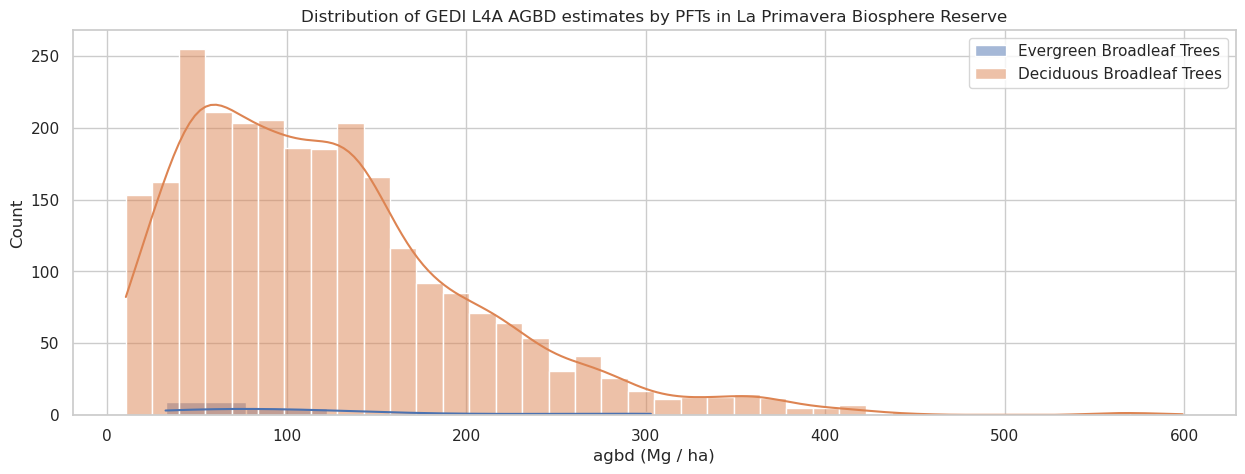

In [9]:
plt.figure(figsize=(15,5))
ax = gdf[mask].groupby('pft_class')['agbd'].\
            apply(lambda x: sns.histplot(x, label = pft_legend[x.name], kde=True))
plt.xlabel('agbd (Mg / ha)')
plt.title('Distribution of GEDI L4A AGBD estimates by PFTs in La Primavera Biosphere Reserve')
plt.legend()
plt.show()

Let's also plot how the AGBD is distributed across elevation ranges for different PFTs.

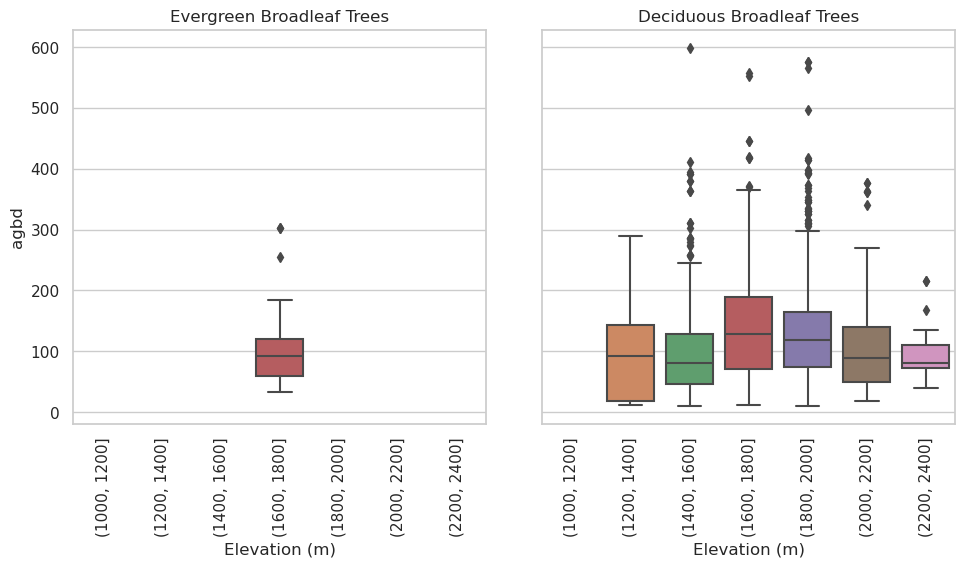

In [10]:
gdf['elev_bin']=pd.cut(gdf['elev_lowestmode'], bins =range(1000, 2600, 200))
g = sns.catplot(x = "elev_bin", y = "agbd", data = gdf[mask], col="pft_class", kind="box")
g.set_xticklabels(rotation=90)
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.set_title(pft_legend[int(float(ax.get_title()))])
g.set_axis_labels("Elevation (m)")
sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)

## Further Resources
Additional tutorials on discovering, accessing, and using GEDI Level 3 and Level 4 data products are available at [https://github.com/ornldaac/gedi_tutorials](https://github.com/ornldaac/gedi_tutorials).